## $ \text{Graph Classification with DGL} $ 


In [1]:
import dgl 
from dgl.data import TUDataset
from dgl.data.utils import split_dataset 
from dgl.nn.pytorch import conv 

c:\Users\EonKim\anaconda3\envs\dgl\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import numpy as np 

np.sqrt(19*60*60)


261.5339366124404

In [27]:
import numpy as np
import time 
import networkx as nx 

import torch 
import torch.nn as nn 
import torch.nn.functional as F 

import torch.optim as optim 
from torch.utils.data import DataLoader 


## $ \text{Load Dataset} $

본 tutorial에서는 효소(enzymes) 데이터를 사용합니다. node는 각각의 원소를 의미하고, edge는 원소들 간의 연결을 의미합니다. 

그래프에는 0부터 5 사이의 label이 있으며, label은 효소의 type을 의미합니다.

In [16]:
dataset = TUDataset('ENZYMES')

for i in range(len(dataset)):
    dataset[i][0].ndata['node_attr'] = (dataset[i][0].ndata['node_attr']).float()

In [17]:
# 총 600개의 그래프가 있습니다.
graph, label = dataset[0]
print(graph)
print(label)

Graph(num_nodes=37, num_edges=168,
      ndata_schemes={'node_attr': Scheme(shape=(18,), dtype=torch.float32), 'node_labels': Scheme(shape=(1,), dtype=torch.int64), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)})
tensor([5], dtype=torch.int32)


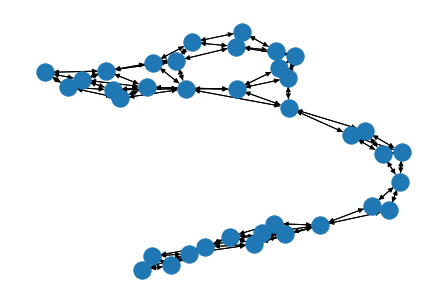

In [19]:
nx.draw_spring(graph.to_networkx())

## $\text{Split dataset into train and validation} $

In [21]:
trainset, valset = split_dataset(dataset, [0.8, 0.2], shuffle=True, random_state=42)

## $\text{Prepare DataLoader} $


In [36]:
def collate_molgraphs_for_classification(data):
    """Batching a list of datapoints for dataloder in classification tasks."""
    graphs, labels = map(list, zip(*data))

    bg = dgl.batch(graphs)
    labels = torch.stack(labels, dim=0)
    return bg, labels 

train_loader = DataLoader(trainset, batch_size=512, collate_fn=collate_molgraphs_for_classification)

val_loader = DataLoader(valset, batch_size=512, collate_fn=collate_molgraphs_for_classification)

In [37]:
class GCNModel(nn.Module):
    def __init__(self,
                 in_feats, 
                 n_hidden, 
                 out_feats):
        super().__init__()
        self.layers = nn.ModuleList([
            conv.GraphConv(in_feats, n_hidden, activation=F.relu), 
            conv.GraphConv(n_hidden, n_hidden, activation=F.relu),
            conv.GraphConv(n_hidden, n_hidden, activation=F.relu)
        ])
        
        self.classifier = nn.Linear(n_hidden, out_feats)
    
    def forward(self, g, features):
        h = features 
        for layer in self.layers:
            h = layer(g, h)
        
        with g.local_scope():
            g.ndata['feat'] = h 
            h_g = dgl.sum_nodes(g, 'feat')
            
        return self.classifier(h_g)

## $\text{Training} $

In [38]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 500 if torch.cuda.is_available() else 50 
model = GCNModel(in_feats = 18, n_hidden = 64, out_feats = 6).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [39]:
def calc_accuracy(pred_y, true_y):
    pred_y = torch.argmax(pred_y, -1)
    return sum((pred_y == true_y).sum().item()) / len(true_y)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time 
    elapsed_mins = elapsed_time // 60 
    elapsed_secs = int(elapsed_time - elapsed_mins*60)
    return elapsed_mins, elapsed_secs 

In [41]:

model.train()
for epoch in range(epochs):
    loss_list = []

    start_time = time.time()
    for batch_id, batch_data in enumerate(train_loader):
        bg, labels = batch_data 
        bg = dgl.add_self_loop(bg)
        atom_feats = bg.ndata.pop('node_attr').float()
        atom_feats, labels = atom_feats.to(device), label.to(device).squeeze(-1)
        
        pred_y = model(bg, atom_feats)
        loss = criterion(pred_y, labels)
        accuracy = calc_accuracy(pred_y, labels)
        
        loss_list.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    end_time = time.time()
    elapsed_mins, elapsed_secs = epoch_time(start_time, end_time)
    print(f'epoch: [{epoch}/{epochs}] | elapsed time: {elapsed_mins}m {elapsed_secs}s') 
    print(f'train loss: {loss.item():.4f}\ttrain accuracy: {accuracy*100:.2f}')       

ValueError: Expected input batch_size (1) to match target batch_size (0).

In [43]:
pred_y.shape

torch.Size([1, 6])

In [44]:
labels.shape

torch.Size([])